In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import gp_derivative as gpd
from scipy.spatial.distance import pdist, cdist, squareform
import scipy.stats as stats
import scipy.linalg as la
from scipy.integrate import solve_ivp
from sur_data import *
from lotka_volterra_analysis import *
from scipy.stats import gaussian_kde

In [87]:
%matplotlib notebook
plt.style.use('seaborn')

In [88]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0]
    dy[1] = a*y[1]-b*y[0]*y[1]
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

In [203]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T_obs = np.linspace(0,10,10)
y = solve_lv(T_obs,y0,a,b,c,d)
dy = lotka_volterra(T_obs,y,a,b,c,d)

# set random seed
np.random.seed(2021)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))
dy_noisy = lotka_volterra(T_obs,y_noisy,a,b,c,d)

# Fitting Surrogates
### 1. Without Noise

In [204]:
kernel1 = gpd.DSquareExp()
kernel2 = gpd.DSquareExp()
gp1 = gpd.DGaussianProcessRegressor(kernel1)
gp2 = gpd.DGaussianProcessRegressor(kernel2)

In [205]:
gp1.fit(T_obs,T_obs,y[0],dy[0])
gp2.fit(T_obs,T_obs,y[1],dy[1])

In [206]:
T_sur = np.linspace(0,10,200)
y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)

In [207]:
y_hr = solve_lv(T_sur,y0,a,b,c,d)
dy_hr = lotka_volterra(T_sur,y_hr,a,b,c,d)

<IPython.core.display.Javascript object>


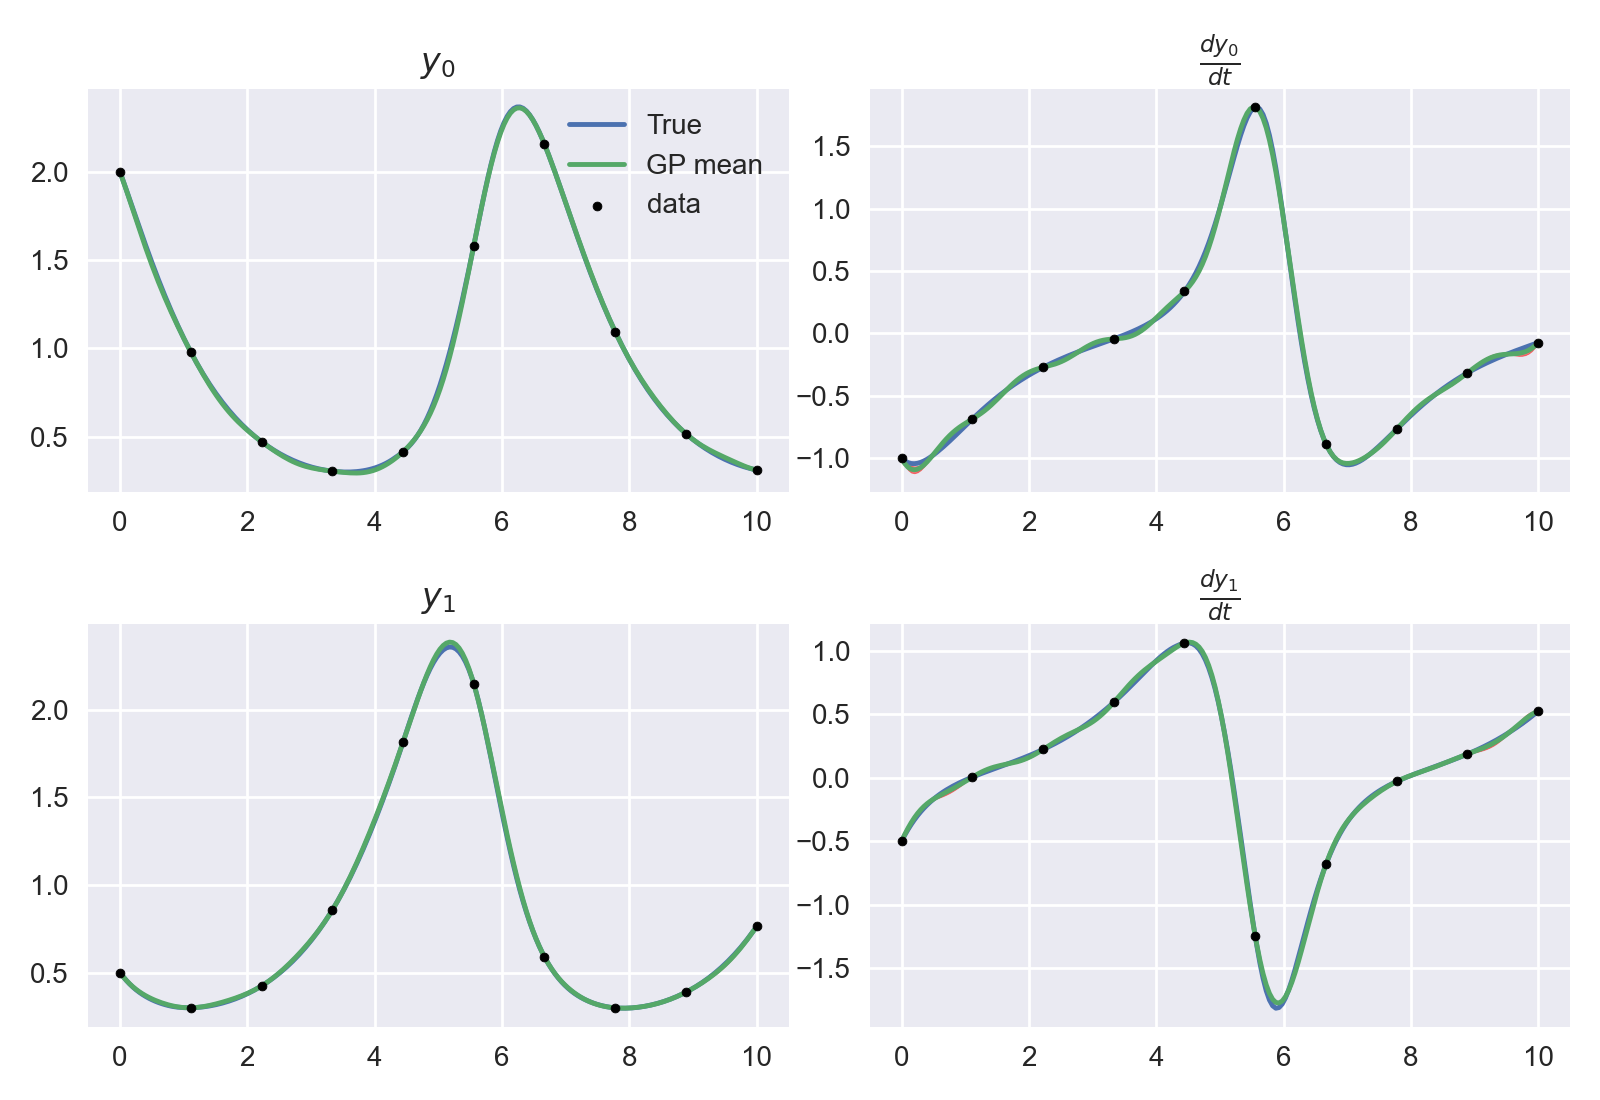

y_0 L2 relative error: 0.006670709910349239
y_1 L2 relative error: 0.006427862403426558


In [208]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.scatter(T_obs,y[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[0],label='True')
plt.plot(T_sur,y1,label='GP mean')
plt.fill_between(T_sur,y1-2*np.diag(cov1)[:len(T_sur)]**0.5,
                 y1+2*np.diag(cov1)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_0$')
plt.legend()
plt.subplot(2,2,2)
plt.scatter(T_obs,dy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[0])
plt.plot(T_sur,dy1)
plt.fill_between(T_sur,dy1-2*np.diag(cov1)[len(T_sur):]**0.5,
                 dy1+2*np.diag(cov1)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_0}{dt}$')
plt.subplot(2,2,3)
plt.scatter(T_obs,y[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[1])
plt.plot(T_sur,y2)
plt.fill_between(T_sur,y2-2*np.diag(cov2)[:len(T_sur)]**0.5,
                 y2+2*np.diag(cov2)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_1$')
plt.subplot(2,2,4)
plt.scatter(T_obs,dy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[1])
plt.plot(T_sur,dy2)
plt.fill_between(T_sur,dy2-2*np.diag(cov2)[len(T_sur):]**0.5,
                 dy2+2*np.diag(cov2)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_1}{dt}$')
plt.tight_layout()
plt.show()

print("y_0 L2 relative error:",la.norm(y_hr[0]-y1)/la.norm(y_hr[0]))
print("y_1 L2 relative error:",la.norm(y_hr[1]-y2)/la.norm(y_hr[1]))

### 2. Noisy Data, Noiseless Kernels

In [185]:
kernel1 = gpd.DSquareExp()
kernel2 = gpd.DSquareExp()
gp1 = gpd.DGaussianProcessRegressor(kernel1)
gp2 = gpd.DGaussianProcessRegressor(kernel2)

In [186]:
gp1.fit(T_obs,T_obs,y_noisy[0],dy_noisy[0])
gp2.fit(T_obs,T_obs,y_noisy[1],dy_noisy[1])

In [187]:
y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)

<IPython.core.display.Javascript object>


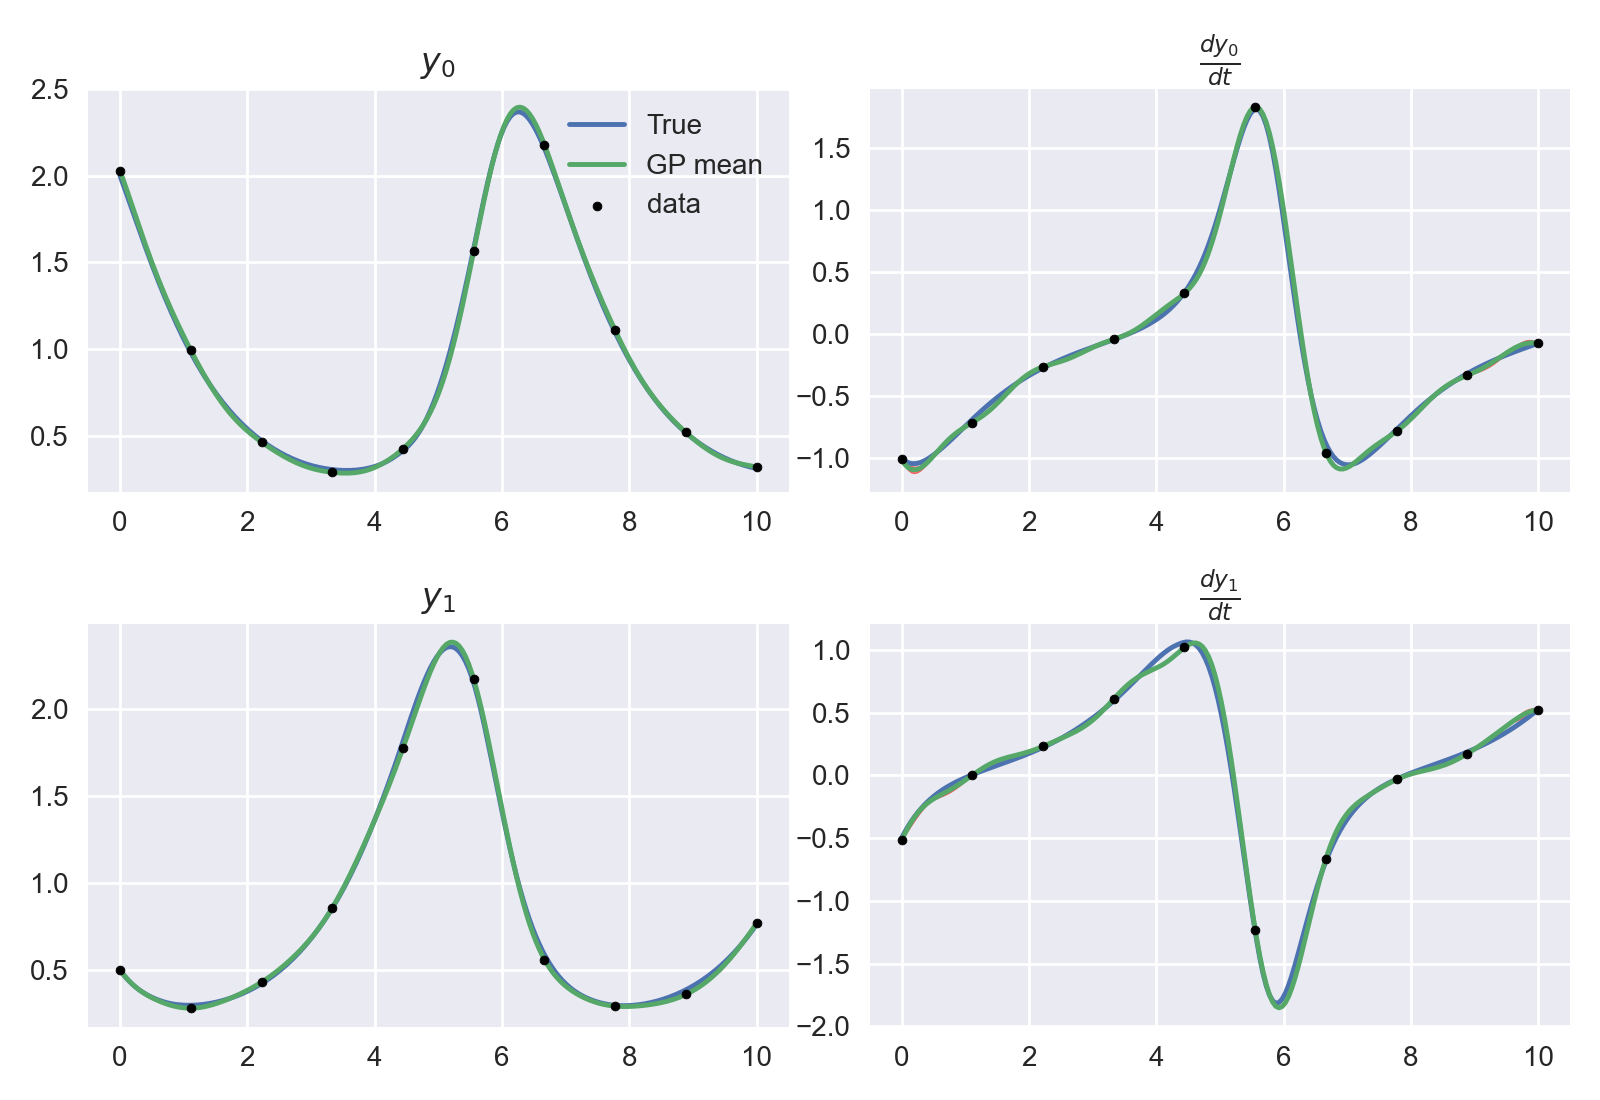

y_0 L2 relative error: 0.012248824776134513
y_1 L2 relative error: 0.01609718936423112


In [188]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.scatter(T_obs,y_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[0],label='True')
plt.plot(T_sur,y1,label='GP mean')
plt.fill_between(T_sur,y1-2*np.diag(cov1)[:len(T_sur)]**0.5,
                 y1+2*np.diag(cov1)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_0$')
plt.legend()
plt.subplot(2,2,2)
plt.scatter(T_obs,dy_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[0])
plt.plot(T_sur,dy1)
plt.fill_between(T_sur,dy1-2*np.diag(cov1)[len(T_sur):]**0.5,
                 dy1+2*np.diag(cov1)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_0}{dt}$')
plt.subplot(2,2,3)
plt.scatter(T_obs,y_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[1])
plt.plot(T_sur,y2)
plt.fill_between(T_sur,y2-2*np.diag(cov2)[:len(T_sur)]**0.5,
                 y2+2*np.diag(cov2)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_1$')
plt.subplot(2,2,4)
plt.scatter(T_obs,dy_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[1])
plt.plot(T_sur,dy2)
plt.fill_between(T_sur,dy2-2*np.diag(cov2)[len(T_sur):]**0.5,
                 dy2+2*np.diag(cov2)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_1}{dt}$')
plt.tight_layout()
plt.show()

print("y_0 L2 relative error:",la.norm(y_hr[0]-y1)/la.norm(y_hr[0]))
print("y_1 L2 relative error:",la.norm(y_hr[1]-y2)/la.norm(y_hr[1]))

### 3. Noisy Data, Noisy Kernel (state only)

In [189]:
kernel1 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=0)
kernel2 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=0)
gp1 = gpd.DGaussianProcessRegressor(kernel1)
gp2 = gpd.DGaussianProcessRegressor(kernel2)

In [190]:
gp1.fit(T_obs,T_obs,y_noisy[0],dy_noisy[0])
gp2.fit(T_obs,T_obs,y_noisy[1],dy_noisy[1])

In [191]:
y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)

<IPython.core.display.Javascript object>


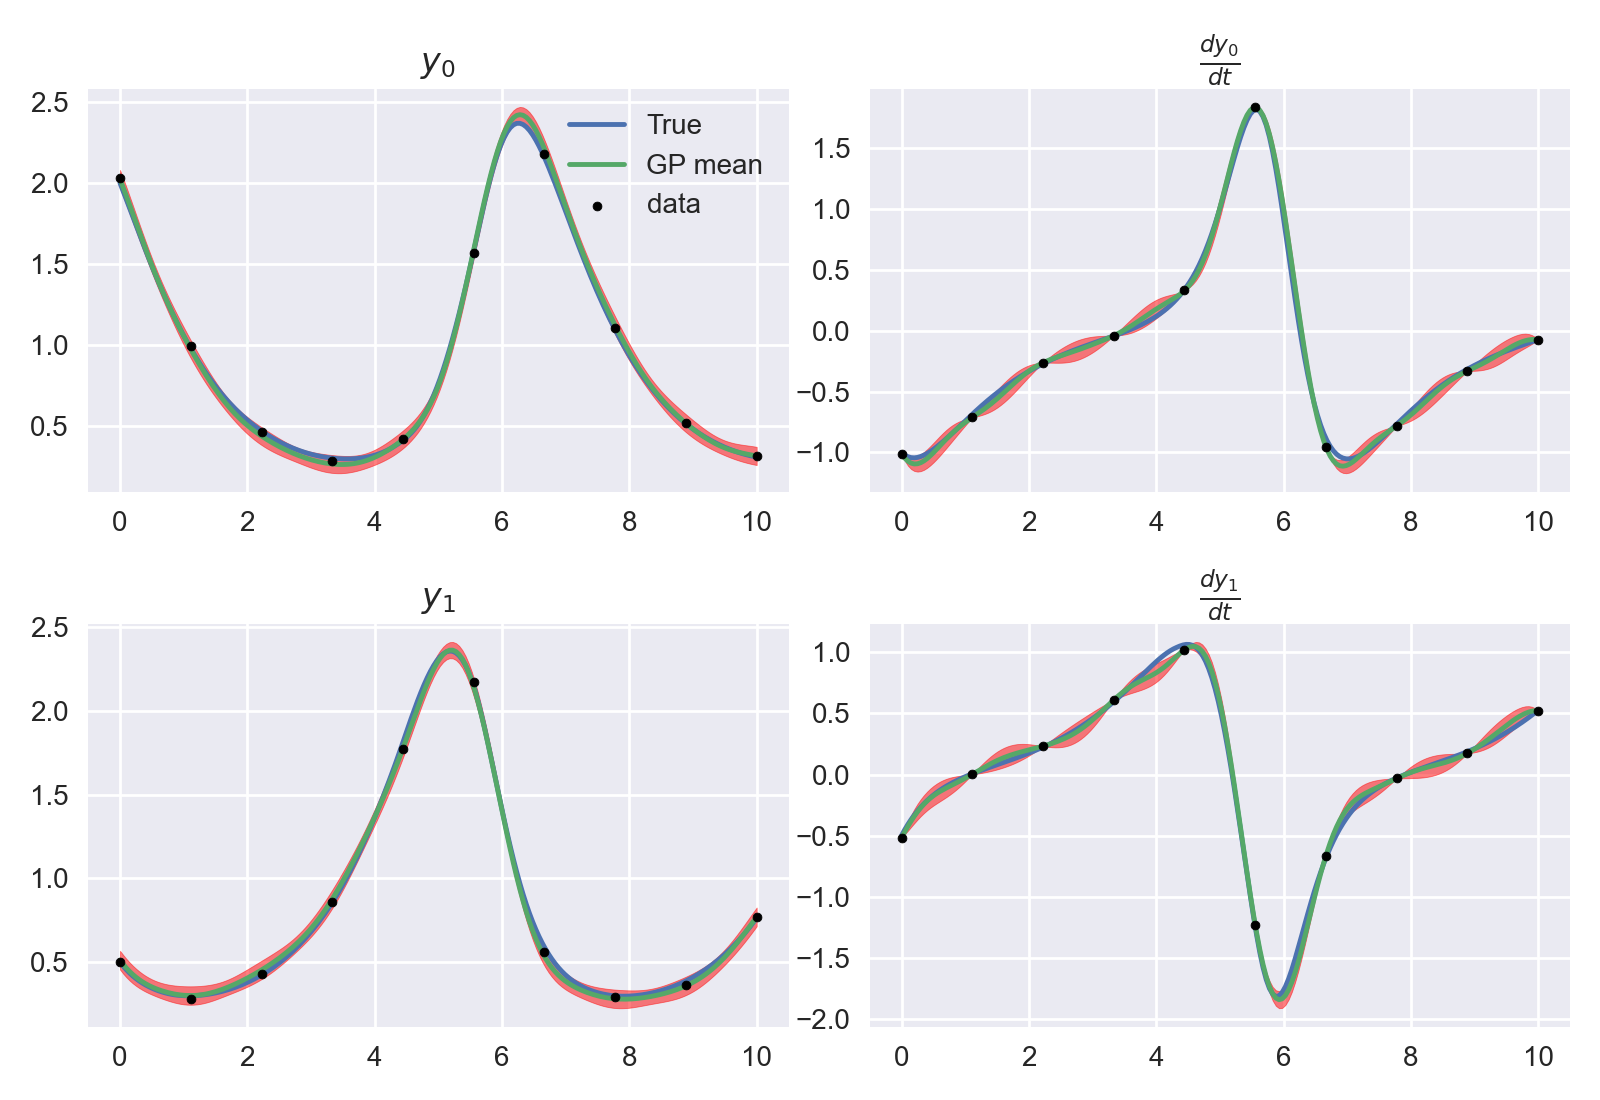

y_0 L2 relative error: 0.02118424440640623
y_1 L2 relative error: 0.0228869552660843


In [192]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.scatter(T_obs,y_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[0],label='True')
plt.plot(T_sur,y1,label='GP mean')
plt.fill_between(T_sur,y1-2*np.diag(cov1)[:len(T_sur)]**0.5,
                 y1+2*np.diag(cov1)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_0$')
plt.legend()
plt.subplot(2,2,2)
plt.scatter(T_obs,dy_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[0])
plt.plot(T_sur,dy1)
plt.fill_between(T_sur,dy1-2*np.diag(cov1)[len(T_sur):]**0.5,
                 dy1+2*np.diag(cov1)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_0}{dt}$')
plt.subplot(2,2,3)
plt.scatter(T_obs,y_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[1])
plt.plot(T_sur,y2)
plt.fill_between(T_sur,y2-2*np.diag(cov2)[:len(T_sur)]**0.5,
                 y2+2*np.diag(cov2)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_1$')
plt.subplot(2,2,4)
plt.scatter(T_obs,dy_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[1])
plt.plot(T_sur,dy2)
plt.fill_between(T_sur,dy2-2*np.diag(cov2)[len(T_sur):]**0.5,
                 dy2+2*np.diag(cov2)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_1}{dt}$')
plt.tight_layout()
plt.show()

print("y_0 L2 relative error:",la.norm(y_hr[0]-y1)/la.norm(y_hr[0]))
print("y_1 L2 relative error:",la.norm(y_hr[1]-y2)/la.norm(y_hr[1]))

### 4. Noisy Data, Noisy Kernel (state and derivative)

In [193]:
kernel1 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=sigma)
kernel2 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=sigma)
gp1 = gpd.DGaussianProcessRegressor(kernel1)
gp2 = gpd.DGaussianProcessRegressor(kernel2)

In [194]:
gp1.fit(T_obs,T_obs,y_noisy[0],dy_noisy[0])
gp2.fit(T_obs,T_obs,y_noisy[1],dy_noisy[1])

In [195]:
y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)

<IPython.core.display.Javascript object>


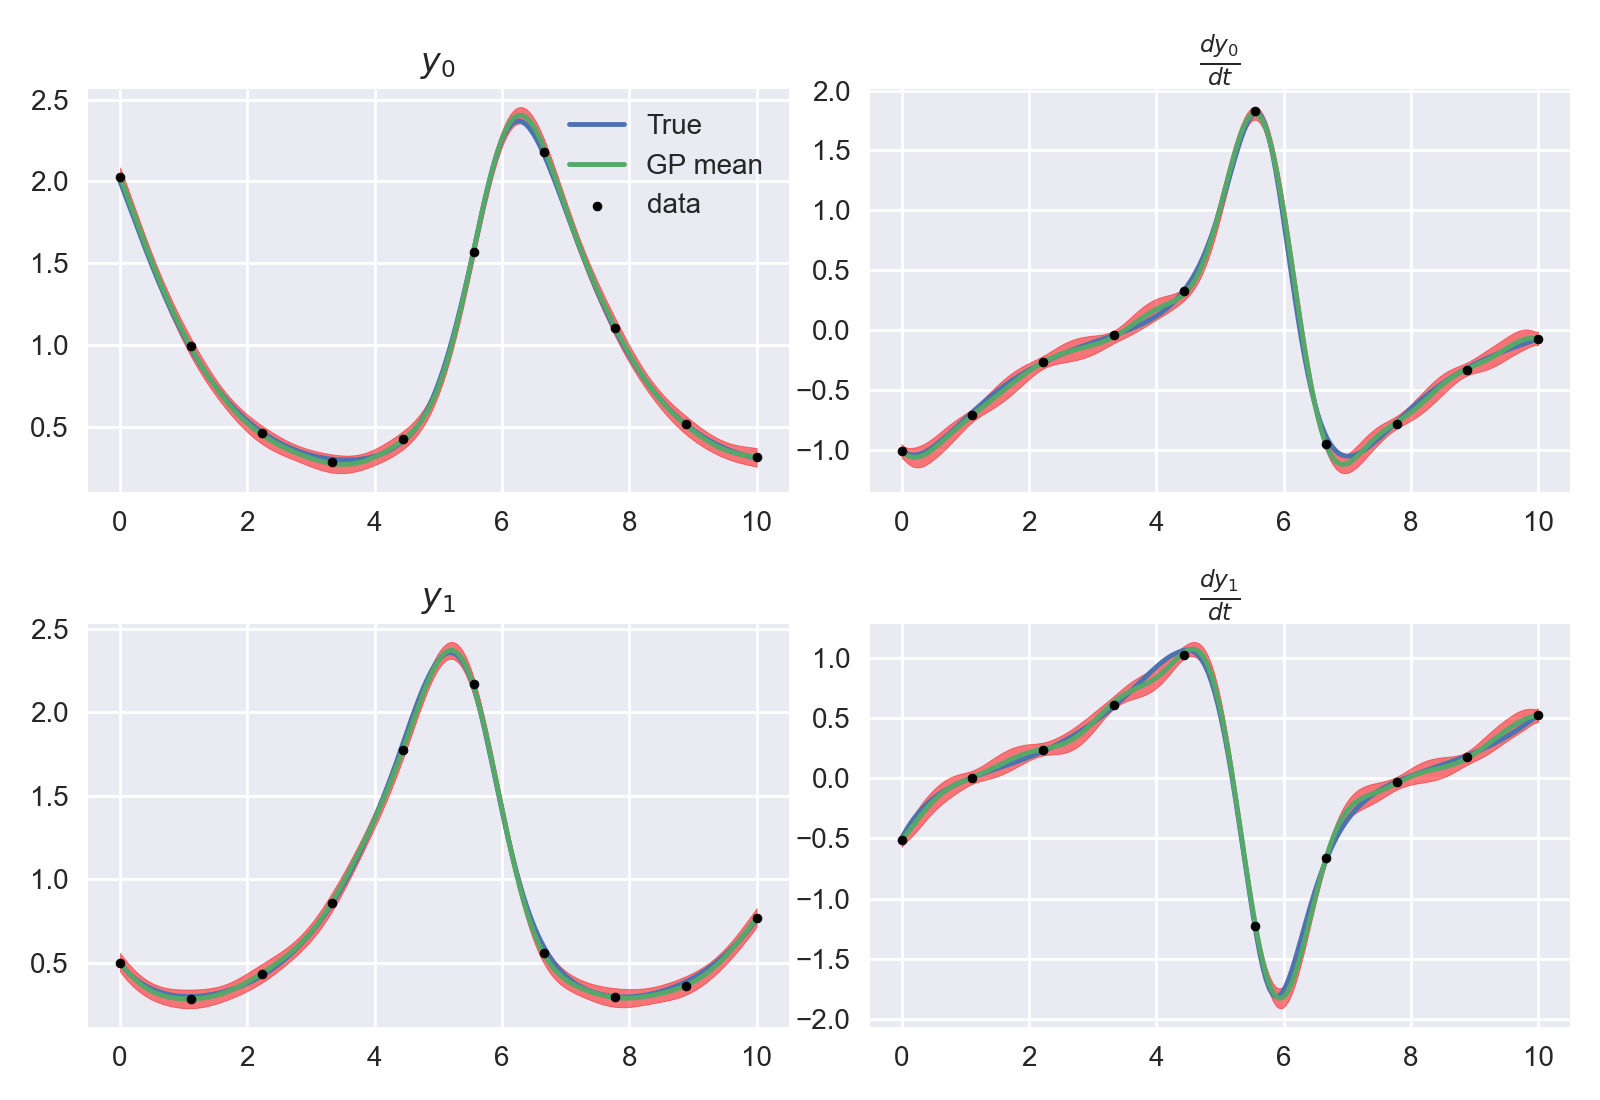

y_0 L2 relative error: 0.014808024546857135
y_1 L2 relative error: 0.016146199043492755


In [196]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.scatter(T_obs,y_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[0],label='True')
plt.plot(T_sur,y1,label='GP mean')
plt.fill_between(T_sur,y1-2*np.diag(cov1)[:len(T_sur)]**0.5,
                 y1+2*np.diag(cov1)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_0$')
plt.legend()
plt.subplot(2,2,2)
plt.scatter(T_obs,dy_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[0])
plt.plot(T_sur,dy1)
plt.fill_between(T_sur,dy1-2*np.diag(cov1)[len(T_sur):]**0.5,
                 dy1+2*np.diag(cov1)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_0}{dt}$')
plt.subplot(2,2,3)
plt.scatter(T_obs,y_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[1])
plt.plot(T_sur,y2)
plt.fill_between(T_sur,y2-2*np.diag(cov2)[:len(T_sur)]**0.5,
                 y2+2*np.diag(cov2)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_1$')
plt.subplot(2,2,4)
plt.scatter(T_obs,dy_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[1])
plt.plot(T_sur,dy2)
plt.fill_between(T_sur,dy2-2*np.diag(cov2)[len(T_sur):]**0.5,
                 dy2+2*np.diag(cov2)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_1}{dt}$')
plt.tight_layout()
plt.show()

print("y_0 L2 relative error:",la.norm(y_hr[0]-y1)/la.norm(y_hr[0]))
print("y_1 L2 relative error:",la.norm(y_hr[1]-y2)/la.norm(y_hr[1]))

# Parameter estimation

In [124]:
# Get weight matrix for precision matrix
# compute eigendecompositions
e1,v1 = la.eig(cov1[:len(T_sur),:len(T_sur)])
e2,v2 = la.eig(cov2[:len(T_sur),:len(T_sur)])

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

In [125]:
# define likelihood and prior
# gaussian likelihood
def llh_wsur(y):
    return -la.norm(W1@(y[0]-y1))**2 - la.norm(W2@(y[1]-y2))**2

# uniform prior
def lpr_sur(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    return solve_lv(T_sur,x[:2],1,x[2],x[3],1)

In [126]:
cov = .00001*np.eye(4)
x0 = np.array([2,.5,1,1])
X_wsur = rw_metropolis_hastings(f_sur,llh_wsur,lpr_sur,cov,x0,n=100000,burn_in=10000,update=False,verbose=True)

kdes_wsur = []
for col in X_wsur.T:
    kdes_wsur.append(gaussian_kde(col))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
acceptance rate: 0.13233


<IPython.core.display.Javascript object>


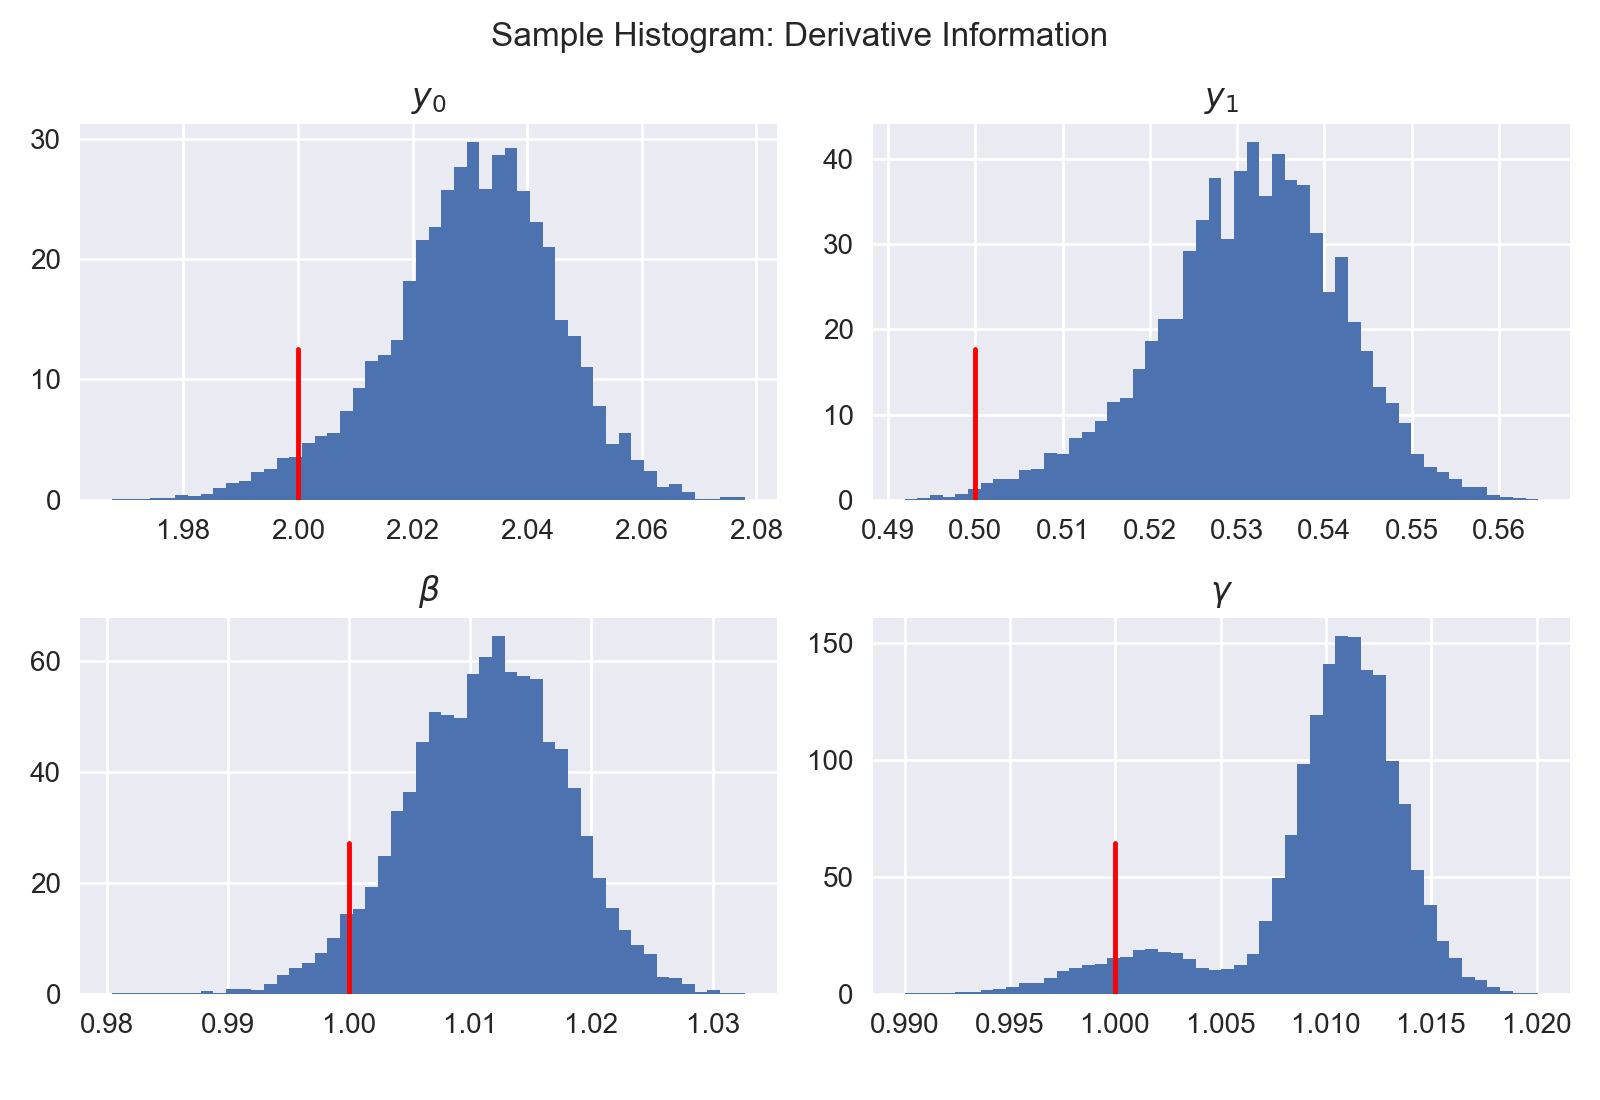

In [127]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_wsur[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_wsur[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_wsur[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_wsur[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Sample Histogram: Derivative Information")
plt.show()
# plt.savefig('figures/std_hist.pdf')

In [71]:
[y_noisy[0,0],y_noisy[1,0],1,1]

[2.0297721810533904, 0.5024841368936545, 1, 1]

In [129]:
data_std = np.load('data/lv_std_nobs5.npz')
data_sur = np.load('data/lv_sur_nobs5_nsur200.npz')
data_wsur = np.load('data/lv_wsur_nobs5_nsur200.npz')

In [130]:
Theta_std = data_std['Theta']
Theta_sur = data_sur['Theta']
Theta_wsur = data_wsur['Theta']

<IPython.core.display.Javascript object>


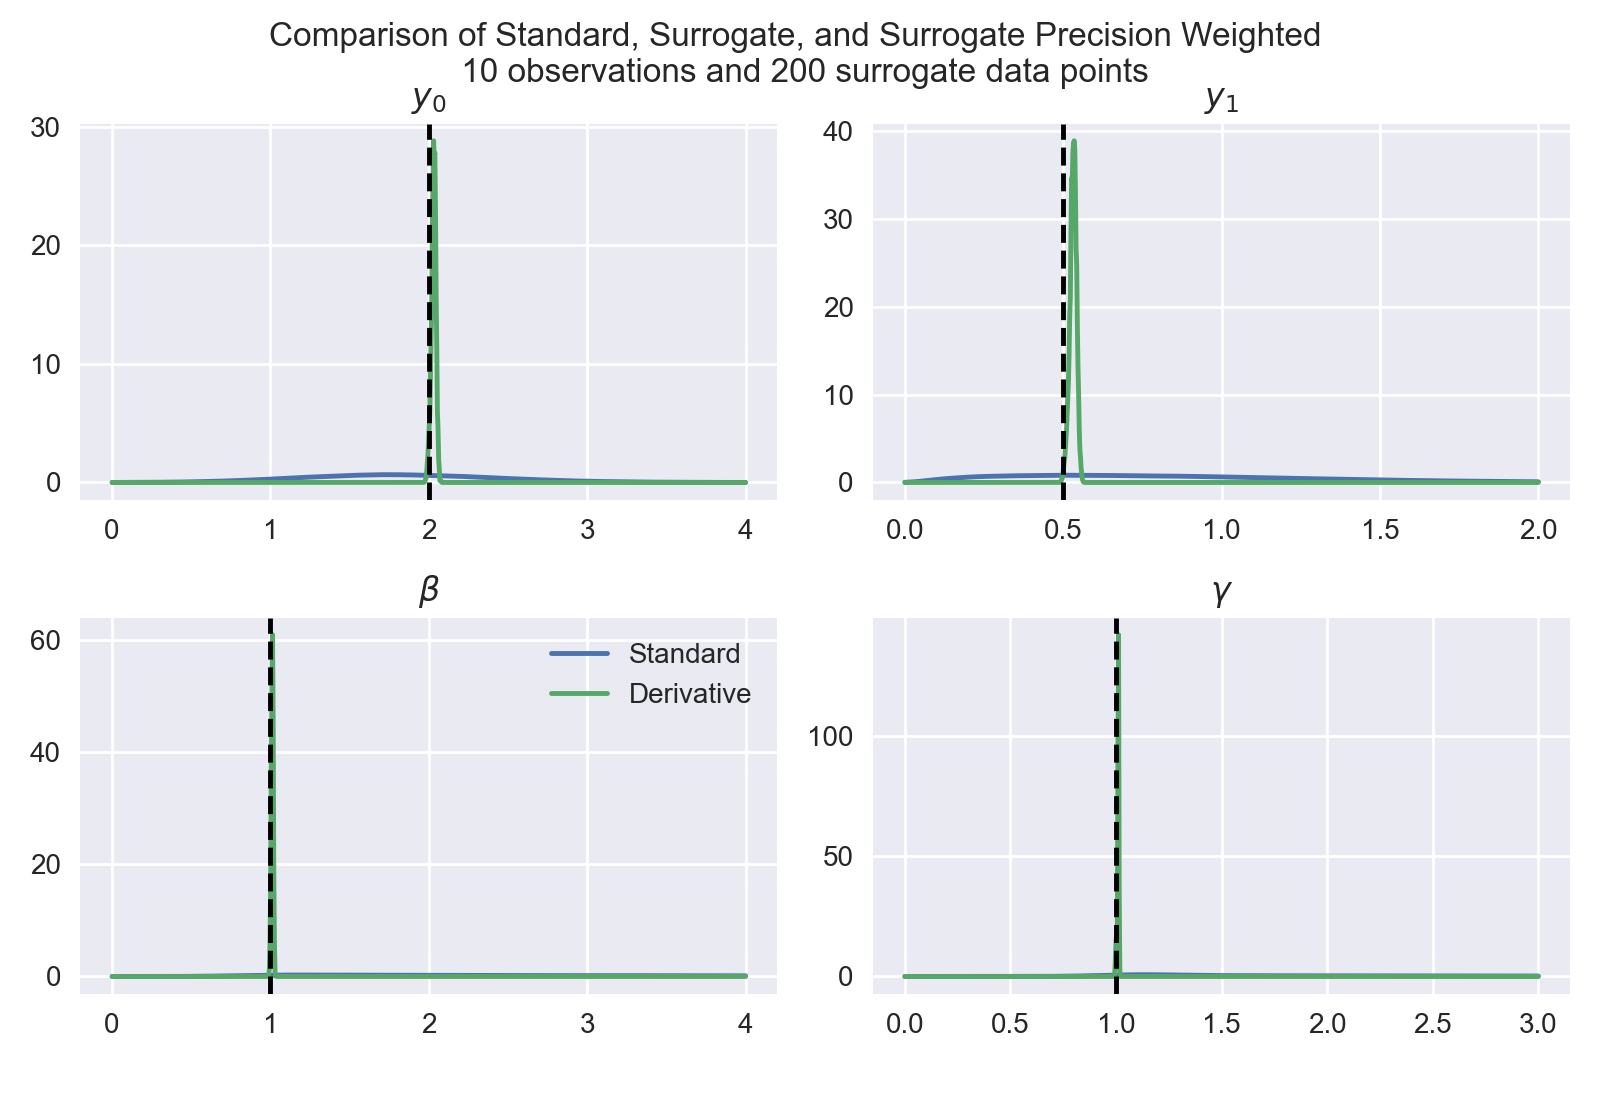

In [131]:
plot_kdes([Theta_std,X_wsur],['Standard','Derivative'],[2,.5,1,1],
          'comparison_test.pdf','Comparison of Standard, Surrogate, and Surrogate Precision Weighted \n 10 observations and 200 surrogate data points')

<IPython.core.display.Javascript object>


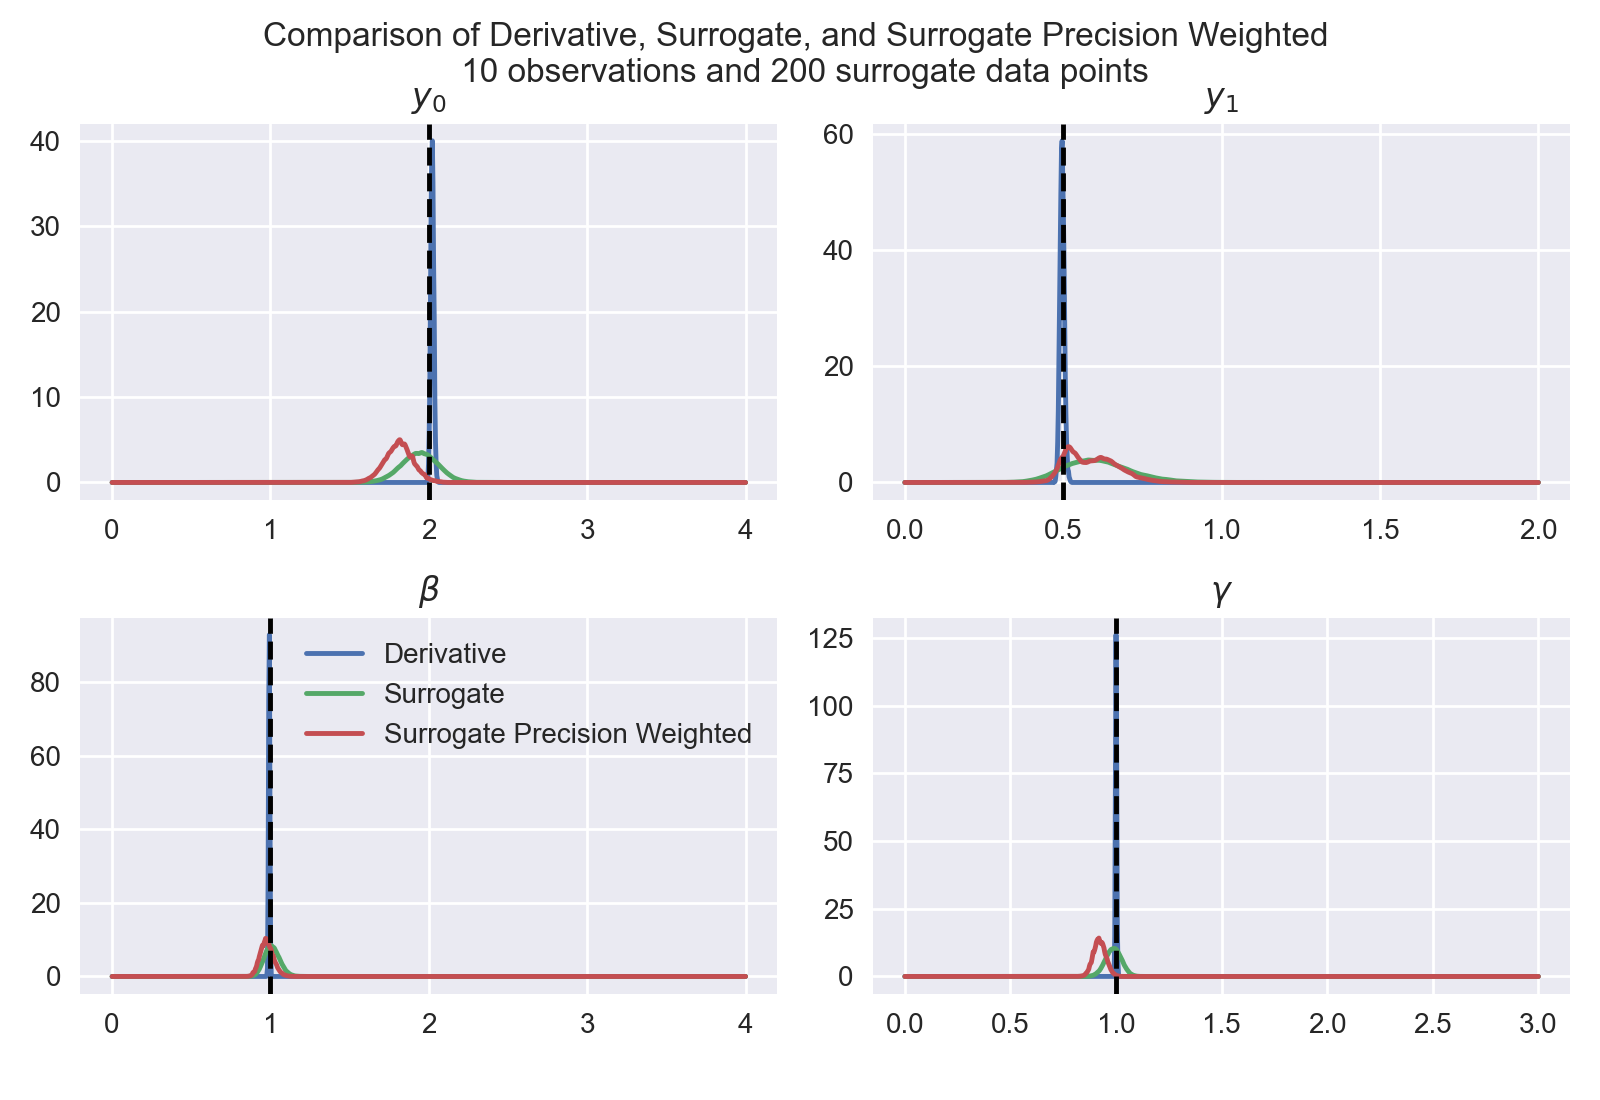

In [113]:
plot_kdes([X_wsur,Theta_sur,Theta_wsur],['Derivative','Surrogate','Surrogate Precision Weighted'],[2,.5,1,1],
          'comparison_test.pdf','Comparison of Derivative, Surrogate, and Surrogate Precision Weighted \n 10 observations and 200 surrogate data points')

<IPython.core.display.Javascript object>


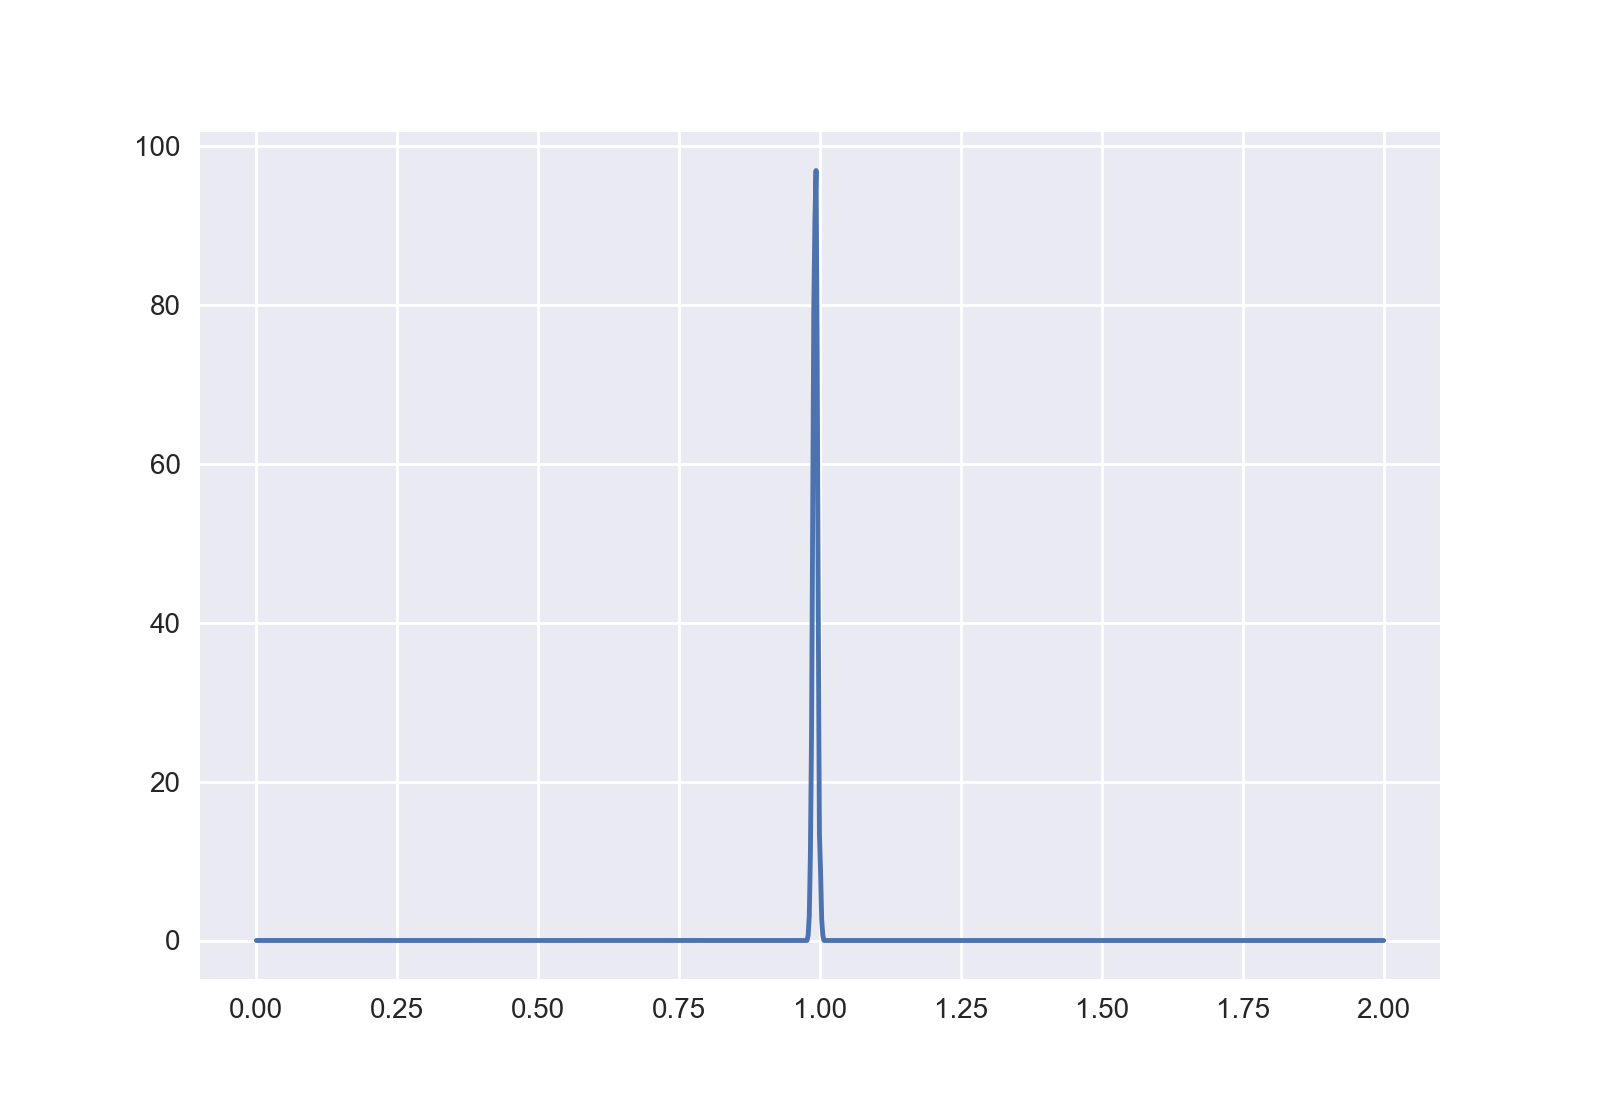

In [82]:
fig = plt.figure()
x = np.linspace(0,2,1000)
plt.plot(x,kdes_wsur[2].pdf(x))
plt.show()